### Daily Observations

- To do list

- Remove patients that are in the 0.004 of the few missing symptoms
- It would be better to look at the distribution before actually removing everything (done below) as some symptoms might be checked hourly

#### 
Please note that due to the low ammount of negative patients tested positive for Ebola,the daily observations data will be used for prognosis and not diagnosis. That is, we will try and predict the outcome for patients that contracted the Ebola Virus. This shows will be further discussed below.

We reckon the cause for the low ebola negative numbers compared to the linelist dataset is because people who are tested positive would be more likely to be sent to Guéckédou (the clinic). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pyreadstat
import datetime

In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
from proj2_HELPERS_ import *


from yellowbrick.model_selection import ValidationCurve

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [3]:
df_line = pd.read_csv('../../../../Data_project2/part_2/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_line.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


In [4]:
df_clinical = pd.read_csv('../../../../Data_project2/part_2/EGOYQN_Gueckedou_clinFU_cleaned_pos_and_neg_2019_November.csv', encoding = 'ISO-8859-1')
df_clinical.head()

C:\Users\Cedric\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,mningit,encphal,erysip,cardio,fessier,epilep,mendis,otherco,notesread,dup
0,G100,4/14/2014,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
1,G100,4/14/2014,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
2,G100,4/16/2014,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
3,G100,4/15/2014,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
4,G100,4/15/2014,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0


#### Ebola tested patients in Linelist

Apply dictionary to ebola data
where 1 is positive, 0 is negative and -1 unknown
2 is probable and we decided to put it in the positive category, 3 and 9 are unknwon 

In [5]:
df_line['epistat'].value_counts(dropna=False)

1    1372
0     978
2     135
3      13
9       2
Name: epistat, dtype: int64

In [6]:
dict_ebola_answer = {0:0, 1:1, 2:1, 3:-1, 9:-1, '.':-1}
df_line['epistat'] = df_line['epistat'].apply(lambda x : dict_ebola_answer[x])


In [7]:
df_line['epistat'].value_counts()

 1    1507
 0     978
-1      15
Name: epistat, dtype: int64

To the Clinical data we add the "epistat" (positive/negative to Ebola) feature from the linelist datafile, the "datsym" representing the estimated start of symptoms and the "outcome" (Death/survival), the outcome, the age and the sex of the patients

We create a new feature name "dt" which takes the difference of time between the appearance of the first symptoms and the admittance to the clinic. 

In [8]:
# Joining the data_sets 
df_clinical= df_clinical.join(df_line.set_index('msfid')[['datsym', 'epistat', 'outcome', 'age', 'sex']], on='msfid')


df_clinical.datclin = pd.to_datetime(df_clinical.datclin)
df_clinical.datsym = pd.to_datetime(df_clinical.datsym)

# Create feature with difference in dates between start of symptoms and start at the clinic
df_clinical['dt'] = (df_clinical.datclin - df_clinical.datsym).dt.days

In [9]:
df_clinical

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,mendis,otherco,notesread,dup,datsym,epistat,outcome,age,sex,dt
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,5.0
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,5.0
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,7.0
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,6.0
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,G1841,2014-11-20,9,G1841_20nov2014_9,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0
13762,G1841,2014-11-20,16,G1841_20nov2014_16,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0
13763,G1841,2014-11-21,9,G1841_21nov2014_9,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,16.0
13764,G1934,2014-11-16,9,G1934_16nov2014_9,1,1,1,1,1,0,...,8,NaN,Yes,0,2014-11-12,1.0,1,40.0,1.0,4.0


In [10]:
df_clinical['dt'].value_counts()

 7.0        1154
 5.0        1106
 6.0        1100
 8.0        1094
 4.0         957
            ... 
-41775.0       1
-41735.0       1
-41727.0       1
-41726.0       1
-41805.0       1
Name: dt, Length: 105, dtype: int64

In [11]:
# Let's have a look at people whose symptoms appears before their admittance
df_clinical[df_clinical['dt'] < 0]['dt'].value_counts()

-1.0        7
-3.0        4
-41895.0    3
-4.0        3
-41882.0    3
-41864.0    3
-2.0        2
-41881.0    2
-41865.0    2
-41896.0    2
-41870.0    2
-6.0        2
-41880.0    2
-5.0        2
-41775.0    1
-41956.0    1
-41735.0    1
-41939.0    1
-41805.0    1
-41897.0    1
-41893.0    1
-41726.0    1
-41925.0    1
-41883.0    1
-41869.0    1
-41862.0    1
-41871.0    1
-41727.0    1
-41868.0    1
Name: dt, dtype: int64

In [12]:
# We remove obersvation with absurd values, here set at a difference of over 40 thousand days
# removed 34 observations
df_clinical = df_clinical[df_clinical['dt'] > -40000]

In [13]:
df_clinical['msfid'].nunique()

769

In [14]:
# Ebola positive samples
df_clinical[df_clinical['epistat'] == 1].count()

msfid      13423
datclin    13423
timclin    13423
unid       13423
ceph       13423
           ...  
epistat    13423
outcome    13423
age        13423
sex        13423
dt         13423
Length: 119, dtype: int64

In [15]:
# Ebola negative samples
df_clinical[df_clinical['epistat'] == 0].count()

msfid      132
datclin    132
timclin    132
unid       132
ceph       132
          ... 
epistat    132
outcome    132
age        132
sex        132
dt         132
Length: 119, dtype: int64

In [16]:
# We only have 12 unique patients in Clinical that at some point compared to 769 patients
df_clinical[df_clinical['epistat'] == 0].nunique()

msfid       12
datclin     35
timclin     18
unid       130
ceph         2
          ... 
epistat      1
outcome      2
age         12
sex          3
dt          17
Length: 119, dtype: int64

We will therefore only look at prognosis and not diagnosis, let us drop the patients that are ebola negative

In [17]:
df_clinical = df_clinical[df_clinical['epistat'] != 0]

In [18]:
# Sanity check
df_clinical['epistat'].value_counts(dropna = False)

1.0    13423
Name: epistat, dtype: int64

### Age

In [19]:
(df_clinical['age']== 999).sum()
df_clinical['age'].replace(999, np.nan, inplace = True)

In [20]:
df_clinical['age'].replace(999, np.nan, inplace = True)

In [21]:
# Remplace the nan values by the median age
df_clinical['age'].fillna(df_line['age'].median(),inplace = True)

### Sex

In [22]:
df_sex = df_clinical['sex']

dict_sex = {1: 1 ,2:0, 9: -1}
df_sex = df_sex.apply(lambda x : dict_sex[x])

# We'll apply one hot encoding later in the notebook

## Distribution of time spent at the clinic

We are interested into looking at the possible evolution of the patients at the clinic for a few days in a row to see how the symptoms and other features will influence the outcome. Knowing the likely causes and symptoms that make you more prone to decease would increase the chance of making good decisions for the nurses and doctors

In [23]:
# First day of patient at the clinic
df_min = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.min()).reset_index().rename(columns={'datclin':'first_date'})

df_min

,msfid,first_date
0,G100,2014-04-11
1,G1000,2014-09-17
2,G1001,2014-09-17
3,G1002,2014-09-17
4,G1004,2014-09-18
...,...,...
752,G993,2014-09-16
753,G994,2014-09-18
754,G996,2014-09-19
755,G998,2014-09-17


In [24]:
# Merge with original data frame
df_mer_date = df_clinical.merge(df_min, on = 'msfid', how = 'left')


In [25]:
# Time stayed at the clinic. We look at unique dates since the observations are daily
df_stay = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.nunique()).reset_index().rename(columns={'datclin':'Time_stayed'})

df_stay

,msfid,Time_stayed
0,G100,10
1,G1000,2
2,G1001,3
3,G1002,18
4,G1004,3
...,...,...
752,G993,11
753,G994,7
754,G996,3
755,G998,9


Text(0.5, 0, 'Number of days')

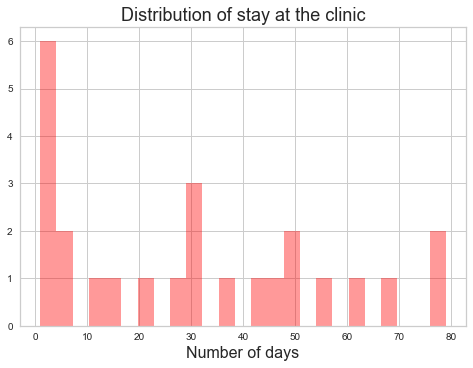

In [26]:

#df_stay['Time_stayed'].value_counts().hist(bins = 25)

sns.distplot(df_stay['Time_stayed'].value_counts(), kde=False, color='red', bins=25)
plt.title('Distribution of stay at the clinic', fontsize=18)
plt.xlabel('Number of days', fontsize=16)


In [27]:
df_stay['Time_stayed'].value_counts().sort_values(ascending = False)

3     79
5     79
2     68
4     63
7     56
8     49
9     49
6     45
10    42
11    37
12    30
13    30
15    30
1     29
14    20
17    15
16    12
19     6
18     5
21     4
20     3
24     2
22     2
23     1
25     1
Name: Time_stayed, dtype: int64

## *The results above, allow us to decide we'll take patients that have stayed at least 5 days, this will enable us to keep as much continious data as possible in this dataset* 
We decided to keep 5 instead of 3, this would indeed yield to less patients, but we would get a better reprsentation of delevopment over time

In [28]:
# How many patients stayed 5 or more days
(df_stay['Time_stayed']> 4).sum()

518

In [29]:
df_stay['Time_stayed'].value_counts().sum()

757

We keep 523 patients out of 769 !

In [30]:
df_selected = df_stay[(df_stay['Time_stayed']> 4)] 
df_selected

,msfid,Time_stayed
0,G100,10
3,G1002,18
5,G1005,7
6,G1006,9
7,G1007,8
...,...,...
750,G991,9
751,G992,5
752,G993,11
753,G994,7


In [31]:
df_selected_ml = df_mer_date.merge(df_selected, on = 'msfid', how = 'inner')
df_selected_ml

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,7.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12049,G2493,2015-01-15,6,G2493_15jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,14.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


In [32]:
# strictly inferior to 5 because we start at 0 :) 
df_5_days = df_selected_ml[df_selected_ml['datclin']- df_selected_ml['first_date'] < '5 days']

df_5_days

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
5,G100,2014-04-15,9,G100_15apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,G2493,2015-01-14,6,G2493_14jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


# Let us drop features that are duplicated or not essential 
df_5_days.drop(columns = ['timclin','unid'])

In [33]:
df_5_days[(df_5_days['msfid'] =='G2493')]['datclin']

12040   2015-01-12
12041   2015-01-12
12042   2015-01-12
12043   2015-01-10
12044   2015-01-11
12045   2015-01-11
12046   2015-01-12
12047   2015-01-14
12048   2015-01-14
12050   2015-01-13
12051   2015-01-13
12052   2015-01-13
Name: datclin, dtype: datetime64[ns]

In [34]:
## Remove samples from patienrs that stayed longer than 5 days

An improvement to the model, would be to group them by day ! Like symptoms are added to one another 

df_daily = df_ml_selected.groupby(by = ['msfid', 'datclin'])

df_daily

# Now we fuse the observations that were taken on the same day

In [198]:
list_of_symptoms=[]
for i, name in enumerate(df_5_days.columns):
    if all(str(x) in ['0', '1', '2', '3', '8', '9', "."] for x in list(df_5_days[name].value_counts().index)):
        if name != 'outcome':  # We don't take the 'outcome' because this will be our target labels so they will be added to the final dataframe later
            list_of_symptoms.append(name)

list_of_constants = []
for i, name in enumerate(df_5_days.columns):
    grouped = df_5_days.groupby(by= ['msfid', 'datclin']).nunique()
    if name not in ['msfid', 'datclin', 'outcome']: # outcome is for later
        if grouped[name].sum() == len(grouped[name]): # if the sum on the column = its lenght => it had only 1's => only 1 unique element per day
            list_of_constants.append(name)

In [199]:
print(list_of_symptoms)
print(list_of_constants)

['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', 'anorc', 'nausc', 'vomit', 'abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', 'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', 'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', 'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc', 'parat', 'coartt', 'artest', 'ppnt', 'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt', 'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz', 'cta', 'metro', 'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro', 'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso', 'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc', 'perfal', 'malari', 'hivpos', 'mningit', 'encphal', 'erysip', 'cardio', 'fessier', 'epilep', 'mendis', 'dup']
['datsym', 'epistat', 'age', 'sex', 'dt', 'first_date', 'Ti

In [200]:
# rapid check : we don't want an overlap of the lists
print(set(list_of_symptoms) & set(list_of_constants))

set()


In [201]:
def merger_for_const(df, list_of_constants): # fuse entries accross the day for when they are the same
    df_cut = df[['msfid', 'datclin'] + list_of_constants].copy() 
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).head(1) # just assign the first entry of the day
    return df_fusion.set_index(['msfid', 'datclin']) # Need to specify index (.head() does not automaticlly keed the same group structure as the other methods of the class)

In [202]:
# Make a small dictionnary to reformat the symptoms 
dict_read_symptoms = {
    0  : 0,
    1  : 1,
    '0': 0,
    '1': 1,
    '9': np.nan,
    9  : np.nan,
    8  : np.nan,
    '8': np.nan,
    '.': np.nan
}

In [203]:
def merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms): # Since you can either manifest the symptom or not, just make the sum accross the entries of the day
    # Note that this method assumes that if a symptom is present at some point of the day, the patient still has it at the end of that day
    df_cut = df[['msfid', 'datclin'] + list_of_symptoms].copy()
    df_cut[list_of_symptoms] = df_cut[list_of_symptoms].applymap(lambda x: dict_read_symptoms[x]) # use the dict. to reformat
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).sum()
    df_fusion[df_fusion[list_of_symptoms] > 1] = 1 # in this context, we want that 1 + 1 = 1 
    return df_fusion

In [204]:
rest = list(set(df_5_days.columns) - set(list_of_constants) - set(list_of_symptoms))
print(rest)

['otherco', 'outcome', 'timclin', 'othrtx', 'notesread', 'bp', 'othrhe', 'othrsym', 'unid', 'msfid', 'rrate', 'fevtemp', 'deshcat', 'datclin', 'pouls', 'conscc']


### Now we need to define functions to treat all those odd columns
(except of cours 'msfid', 'datclin' and 'timclin' which are the ones we do this whole operation for, and also 'outcome')

In [205]:
# 'otherco'
df_5_days['otherco'].value_counts()

.         4211
ABSENT     910
na         220
NR           4
absent       2
Name: otherco, dtype: int64

Completely useless column : will not be kept

In [206]:
# 'notesread'
df_5_days['notesread'].value_counts()

Yes    4059
.      1461
No      429
Name: notesread, dtype: int64

Just says wether the notes were readable or not so not relevant here : will not be kept

In [207]:
df_5_days['othrtx'].value_counts()

.              3338
ABSENT         1038
na              256
FAVIPIRAVIR     212
ONDANSETRON      89
               ... 
favirapavir       1
Potassium         1
FAIVPIRAVIR       1
Jus, eau          1
LOPERAMIDE        1
Name: othrtx, Length: 90, dtype: int64

Will be hard/impossible to fuse if there are more than 1 non-null entry per day...
Goes into the 'weird' cathegory

In [208]:
df_5_days['bp'].value_counts()

999    3010
999    2319
100     131
80      107
90       99
110      63
90       38
70       38
120      34
100      20
80       13
70       12
120      10
60        9
60        5
10        5
130       4
110       4
11        3
7         3
50        2
12        2
160       2
150       2
180       1
40        1
74        1
10        1
125       1
104       1
8         1
99        1
114       1
78        1
15        1
130       1
75        1
111       1
Name: bp, dtype: int64

We just need to mind the 999, but then we can take the mean accros the day

In [209]:
df_5_days['othrhe'].value_counts()

.                             3943
ABSENT                        1011
na                             388
SAIGNEMENT DU GENOU GAUCHE       4
rectorrhagie                     2
HEMOROIDES                       2
HEMORRAGIE BUCCALE               1
HEMOROIDES NON THROMBOSES        1
PLAIE AU GENOU                   1
Name: othrhe, dtype: int64

Too few meaningful data... will not be kept

In [210]:
df_5_days['othrsym'].value_counts()

.                       3855
ABSENT                   985
na                       397
CANDIDOSE BUCCALE         17
IRRITATION                 6
                        ... 
PLEURE                     1
Malcou,selles glaire       1
Gargouillement abdo        1
Insomnie                   1
INSOMNIE                   1
Name: othrsym, Length: 74, dtype: int64

Same as 'othrtx' -> in the 'weird' cathegory

In [211]:
df_5_days['unid'].value_counts()

G1579_31oct2014_9     3
G296_30may2014_10     3
G1579_29oct2014_9     3
G824_02sep2014_99     2
G454_27jun2014_99     2
                     ..
G1732_07nov2014_16    1
G1882_15nov2014_16    1
G296_02jun2014_6      1
G335_07jun2014_18     1
G1776_07nov2014_9     1
Name: unid, Length: 5885, dtype: int64

Not relevant information for us : will not be kept

In [212]:
df_5_days['rrate'].value_counts()

999    3238
999    2435
24       32
20       31
28       28
22       27
26       26
32       25
40       17
30       14
23       10
36        9
19        9
27        8
25        7
18        4
48        4
42        3
44        3
56        2
39        2
45        2
21        2
37        1
52        1
33        1
54        1
46        1
43        1
70        1
38        1
98        1
92        1
80        1
Name: rrate, dtype: int64

Same as 'bp'

In [213]:
df_5_days['fevtemp'].value_counts()

99.0    2272
37.0     173
36.7     162
36.6     159
36.5     141
        ... 
32.1       1
32.0       1
32.6       1
33.4       1
33.9       1
Name: fevtemp, Length: 80, dtype: int64

Same as 'bp' (note that here the missing values are noted by 99 instead of 999)

In [214]:
df_5_days['deshcat'].value_counts()

Non rempli                                4542
Pas applicable (non inclus dans fiche)    1394
B: irritable and restless, sunke             6
C: floppy baby/lethargic or unco             4
A: alert, eyes normal, not thirs             3
Name: deshcat, dtype: int64

Not enough data to be meaningful... Will not be kept

In [215]:
df_5_days['pouls'].value_counts()

999    5686
80       39
100      39
90       21
99       14
70       11
88       11
84       11
60       10
120       8
68        7
98        6
82        6
96        6
110       6
108       5
86        5
78        5
89        4
76        4
72        4
92        4
102       3
74        3
104       3
64        3
118       2
112       2
85        2
77        2
115       2
62        2
160       1
38        1
94        1
66        1
107       1
79        1
114       1
91        1
109       1
124       1
95        1
117       1
130       1
Name: pouls, dtype: int64

Same as 'bp'

In [216]:
df_5_days['conscc'].value_counts()

Non rempli                         4011
Pas applicable (non inclus dans    1640
Alert GCS=13,14,15                  231
Voice GCS=9,10,11,12                 36
Pain GCS=4,5,6,7,8                   16
Unresponsive GCS=1,2,3               15
Name: conscc, dtype: int64

No idea how tu use this data... Will not be kept

In [217]:
def merger_for_weird(df, name_of_column): # just take the first non-null entry of the day (and hope it's the only one)
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[df_cut[name_of_column] == '.'] = np.nan
    df_cut[df_cut[name_of_column] == 'na'] = np.nan
    df_cut[df_cut[name_of_column] == 'ABSENT'] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).nth(0, dropna='any') # take the first (array start at 0) non-null element of the group
    return df_fusion

In [218]:
def merger_for_means(df, name_of_column): # will take the mean of entries accros the day
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[name_of_column] = df_cut[name_of_column].astype(float) # some values are '1' instead of 1 , '100' instead of 100 , etc.
    df_cut[df_cut[name_of_column]== 999] = np.nan
    if name_of_column == 'fevtemp': # for some funky reason the missing values in fevtemp are noted with a 99 instead of 999
        df_cut[df_cut[name_of_column] == 99] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).mean()
    return df_fusion

## Now make a single function to do it all

In [219]:
def merge_same_day_observations(df, list_of_symptoms, dict_read_symptoms, list_of_constants):
    # separately make the fusion corresponding to the correct operation
    df_symptoms_fused  = merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms)
    df_constants_fused = merger_for_const(df, list_of_constants)
    df_othrtx_fused    = merger_for_weird(df, 'othrtx')
    df_bp_fused        = merger_for_means(df, 'bp')
    df_othrsym_fused   = merger_for_weird(df, 'othrsym')
    df_rrate_fused     = merger_for_means(df, 'rrate')
    df_fevtemp_fused   = merger_for_means(df, 'fevtemp')
    df_pouls_fused     = merger_for_means(df, 'pouls')
    # Now join them all together
    df_all = df_symptoms_fused.join([
        df_constants_fused,
        df_othrtx_fused,
        df_bp_fused,
        df_othrsym_fused,
        df_rrate_fused,
        df_fevtemp_fused,
        df_pouls_fused
    ])
    return df_all.reset_index()

In [220]:
df = merge_same_day_observations(df_5_days, list_of_symptoms, dict_read_symptoms, list_of_constants)

In [221]:
df

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,sex,dt,first_date,Time_stayed,othrtx,bp,othrsym,rrate,fevtemp,pouls
0,G100,2014-04-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2014-04-11,10,NaN,NaN,NaN,NaN,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,2014-04-11,10,NaN,NaN,NaN,NaN,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,2014-04-11,10,NaN,NaN,NaN,NaN,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,5.0,2014-04-11,10,NaN,NaN,NaN,NaN,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6.0,2014-04-11,10,NaN,NaN,NaN,NaN,36.966667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,G998,2014-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,2014-09-17,9,NaN,NaN,NaN,NaN,34.900000,NaN
2498,G998,2014-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2014-09-17,9,NaN,NaN,NaN,NaN,38.000000,NaN
2499,G998,2014-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2014-09-17,9,NaN,NaN,NaN,NaN,38.500000,NaN
2500,G998,2014-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2014-09-17,9,NaN,NaN,NaN,NaN,38.050000,NaN


In [222]:
# note that is has 113 columns, which is 8 less than df_5_days.
# On the other end, we didn't keep 'timclin', 'outcome', 'otherco', 'notesread', 'othrhe', 'unid', 'deshcat' and 'conscc' so the maths checks out !

# In order to ease notations
Bu

### MSF 
Patients ID 
They might appear multiple times as can be seen from the data frame above. With "datclin", the date at the clinic and "timclin" the time when the patient was taking in charge.

In [37]:
df['msfid']

0         G100
1         G100
3         G100
4         G100
5         G100
         ...  
12047    G2493
12048    G2493
12050    G2493
12051    G2493
12052    G2493
Name: msfid, Length: 5949, dtype: object

In [38]:
df[df['msfid'] == 'G100'].head()

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
5,G100,2014-04-15,9,G100_15apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10


In [39]:
df['msfid'].nunique()

518

### Clinical information

In [40]:
df['datclin']

0       2014-04-14
1       2014-04-14
3       2014-04-15
4       2014-04-15
5       2014-04-15
           ...    
12047   2015-01-14
12048   2015-01-14
12050   2015-01-13
12051   2015-01-13
12052   2015-01-13
Name: datclin, Length: 5949, dtype: datetime64[ns]

In [41]:
df['datclin_day'] = df['datclin'].dt.to_period('D')
df['datclin_month'] = df['datclin'].dt.to_period('M')

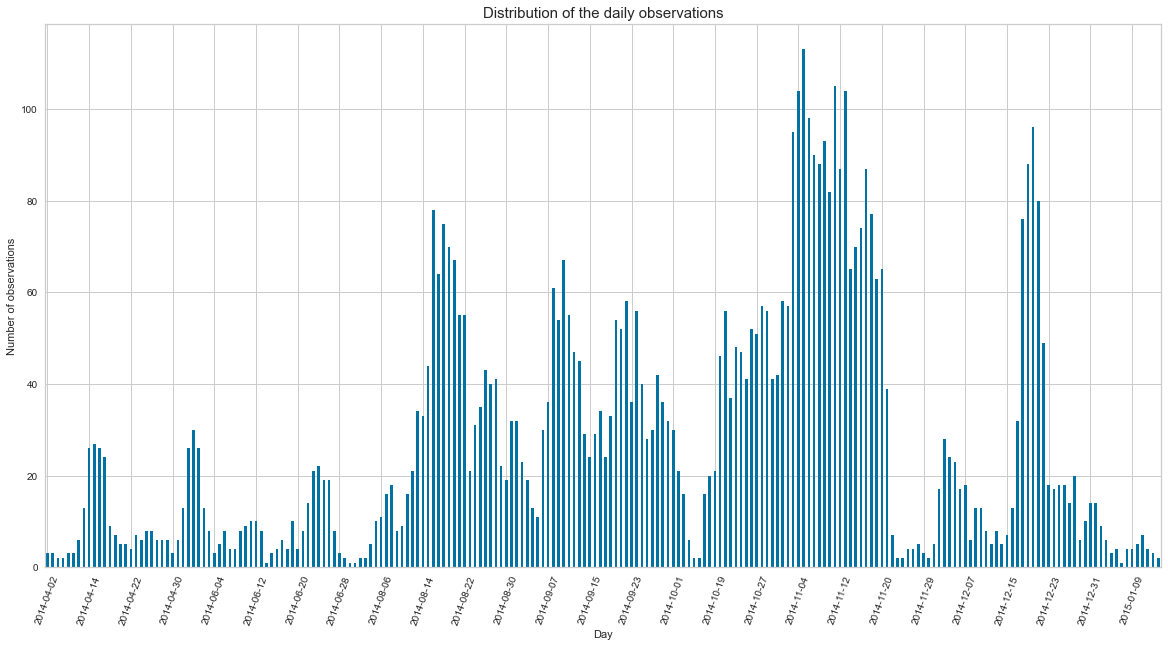

In [42]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_day'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the daily observations",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of observations')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

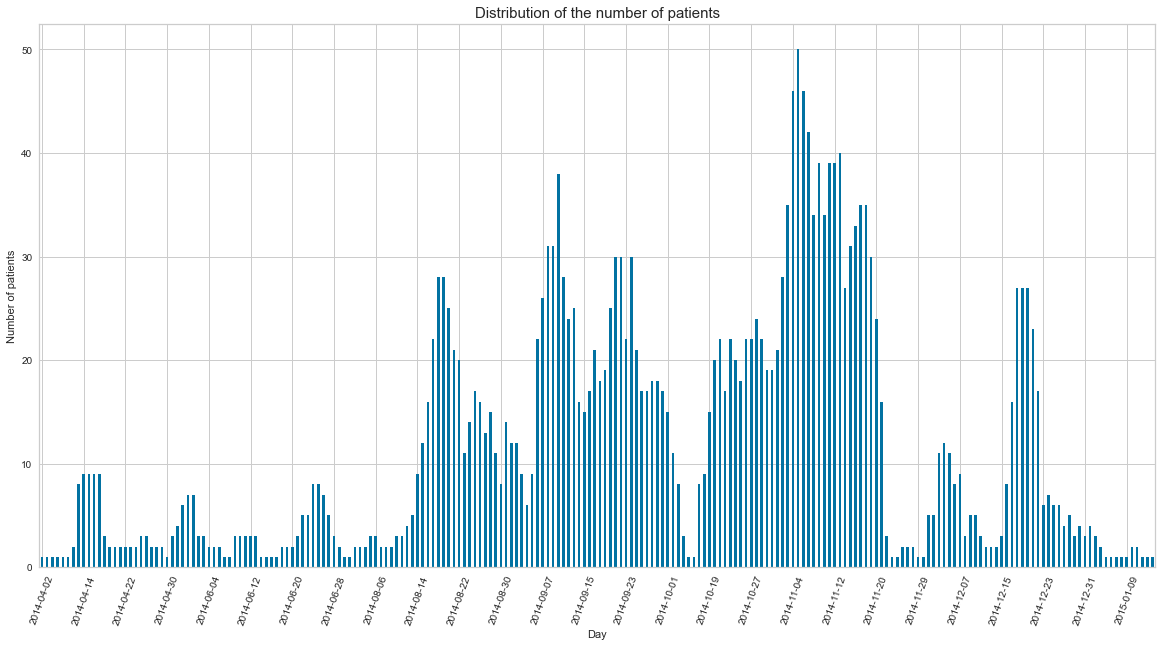

In [43]:
fig, ax = plt.subplots(figsize=(20,10))

df.groupby('datclin_day').msfid.nunique().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the number of patients",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of patients')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

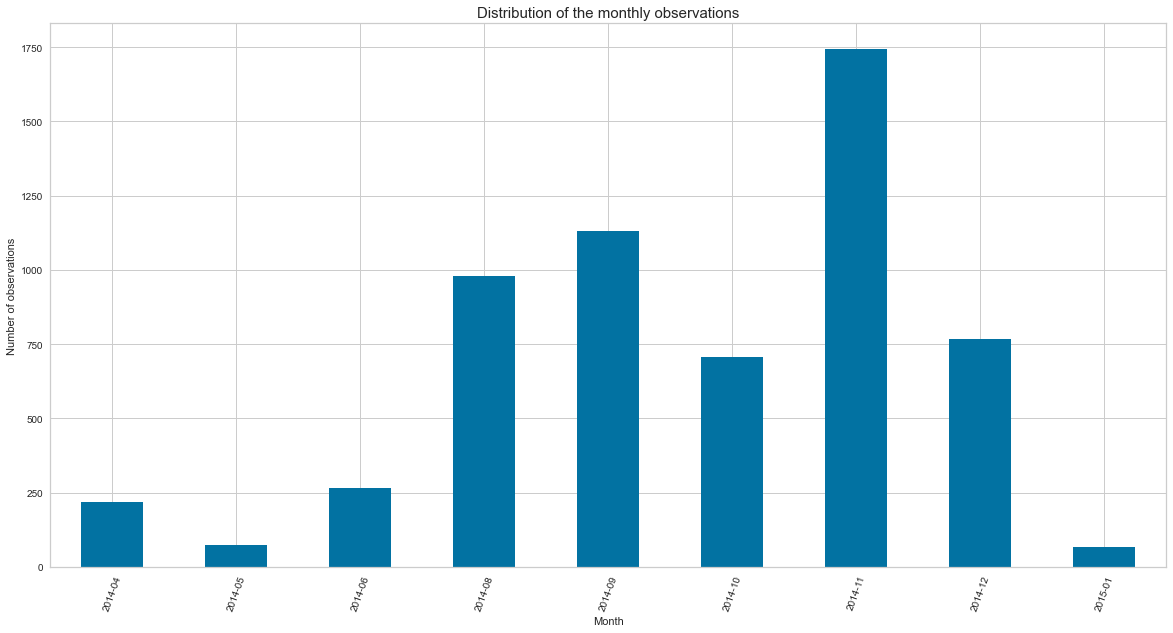

In [44]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_month'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the monthly observations",size=15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of observations')
plt.xticks(rotation=70)
plt.show()

#### Distribution of patients within the day

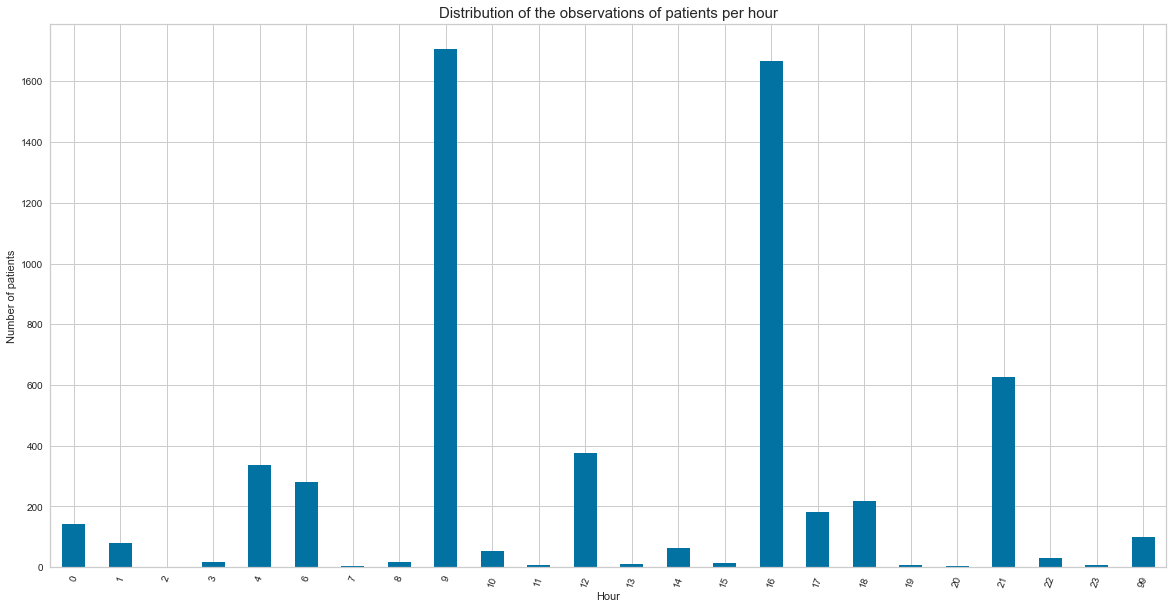

In [45]:
fig, ax = plt.subplots(figsize=(20,10))

df['timclin'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the observations of patients per hour",size=15)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of patients')
plt.xticks(rotation=70)
plt.show()

The unknown hours are represented by 99.

### Categorical symptoms

Dictionary to the symptoms can be found in the folder 

In [46]:
print(df.columns[3:].values)

['unid' 'ceph' 'asthen' 'myalc' 'arthralc' 'fevr' 'oedc' 'chocc' 'anurc'
 'convc' 'swallow' 'hiccups' 'anorc' 'nausc' 'vomit' 'abdopain' 'abdosens'
 'doulqs' 'diarrc' 'gastro' 'cough' 'dyspc' 'resp' 'chestpain' 'vertpain'
 'lombar' 'ictc' 'pruri' 'hepmeg' 'splenmeg' 'erupcut' 'deshyd' 'photoc'
 'occulair' 'tremb' 'friss' 'vert' 'amenn' 'pros' 'desor' 'agitc'
 'othrsym' 'injconj' 'epista' 'gum' 'hemopty' 'hematem' 'stool' 'hemat'
 'vagbl' 'injbl' 'petc' 'othrhe' 'fevtemp' 'pouls' 'bp' 'rrate' 'deshcat'
 'conscc' 'parat' 'coartt' 'artest' 'ppnt' 'orst' 'paracett' 'ciprot'
 'cefixt' 'ceftriaxt' 'multivitt' 'metaclot' 'omept' 'diazt' 'tramadt'
 'ctrz' 'cta' 'metro' 'amox' 'prometh' 'amoclav' 'genta' 'ampi' 'albend'
 'azithro' 'chlor' 'morph' 'tetra' 'fluco' 'mysta' 'busco' 'miso' 'zinc'
 'othrtx' 'ivcare' 'rlt' 'rltg' 'rltk' 'gluc' 'perfal' 'malari' 'hivpos'
 'mningit' 'encphal' 'erysip' 'cardio' 'fessier' 'epilep' 'mendis'
 'otherco' 'notesread' 'dup' 'datsym' 'epistat' 'outcome' 'age' 's

In [47]:
#othrsym and othrhe categorical but a lot of categories
symptoms = ['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', \
            'anorc', 'nausc', 'vomit','abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', \
            'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', \
            'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', \
            'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc']

In [48]:
# Other symptoms 
df['othrsym'].value_counts()

#we shall drop this column as too many missing values
df.drop(columns = 'othrsym', inplace = True)

In [49]:
df_symp = df[symptoms].copy()
df_symp.head()

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,0,0,0,0,.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Looking at possible missing data in symptoms

In [50]:


df_symp.isna().apply(lambda x: sum(x)).sort_values(ascending = False)

petc         0
nausc        0
chestpain    0
resp         0
dyspc        0
cough        0
gastro       0
diarrc       0
doulqs       0
abdosens     0
abdopain     0
vomit        0
anorc        0
injbl        0
hiccups      0
swallow      0
convc        0
anurc        0
chocc        0
oedc         0
fevr         0
arthralc     0
myalc        0
asthen       0
vertpain     0
lombar       0
ictc         0
pruri        0
vagbl        0
hemat        0
stool        0
hematem      0
hemopty      0
gum          0
epista       0
injconj      0
agitc        0
desor        0
pros         0
amenn        0
vert         0
friss        0
tremb        0
occulair     0
photoc       0
deshyd       0
erupcut      0
splenmeg     0
hepmeg       0
ceph         0
dtype: int64

**No nan values for the symptoms** But be careful, they are in this data frame denoted by 8,9 for the symptoms 

In [51]:
# Number of symptoms 
len(symptoms)

50

In [56]:
dict_symp_answer = {
    'Non' : 'No', 
    'Oui' : 'Yes',
    'No' : 'No',
    'Yes' : 'Yes',
    'Non rempli' : 'Unknown', 
    'Pas applicable (non inclus dans fiche)' : 'Unknown',
    'Unknown' : 'Unknown', 
    '0': 'No',0:'No',
    1:'Yes',
    '1':'Yes',
    '9':'Unknown',
    9:'Unknown',
    8:'Unknown',
    '8':'Unknown',
    '.':'Unknown'
}
df_symp = df_symp.applymap(lambda x: dict_symp_answer[x])
#df_symp = df_symp.astype('string')
df_symp.fillna('Unknown', inplace = True)


In [57]:
# Samples with only unknowns 
df_info_symp_unknown = df_symp.eq('Unknown', axis=0).all(1)
sum(df_info_symp_unknown)

294

__850 samples (not patients) with only unknown__

In [58]:
df_symp = df_symp[~df_info_symp_unknown]
df_symp

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
5,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12048,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12050,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12051,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No


We plot the symptoms distribution for all the possible observations. 

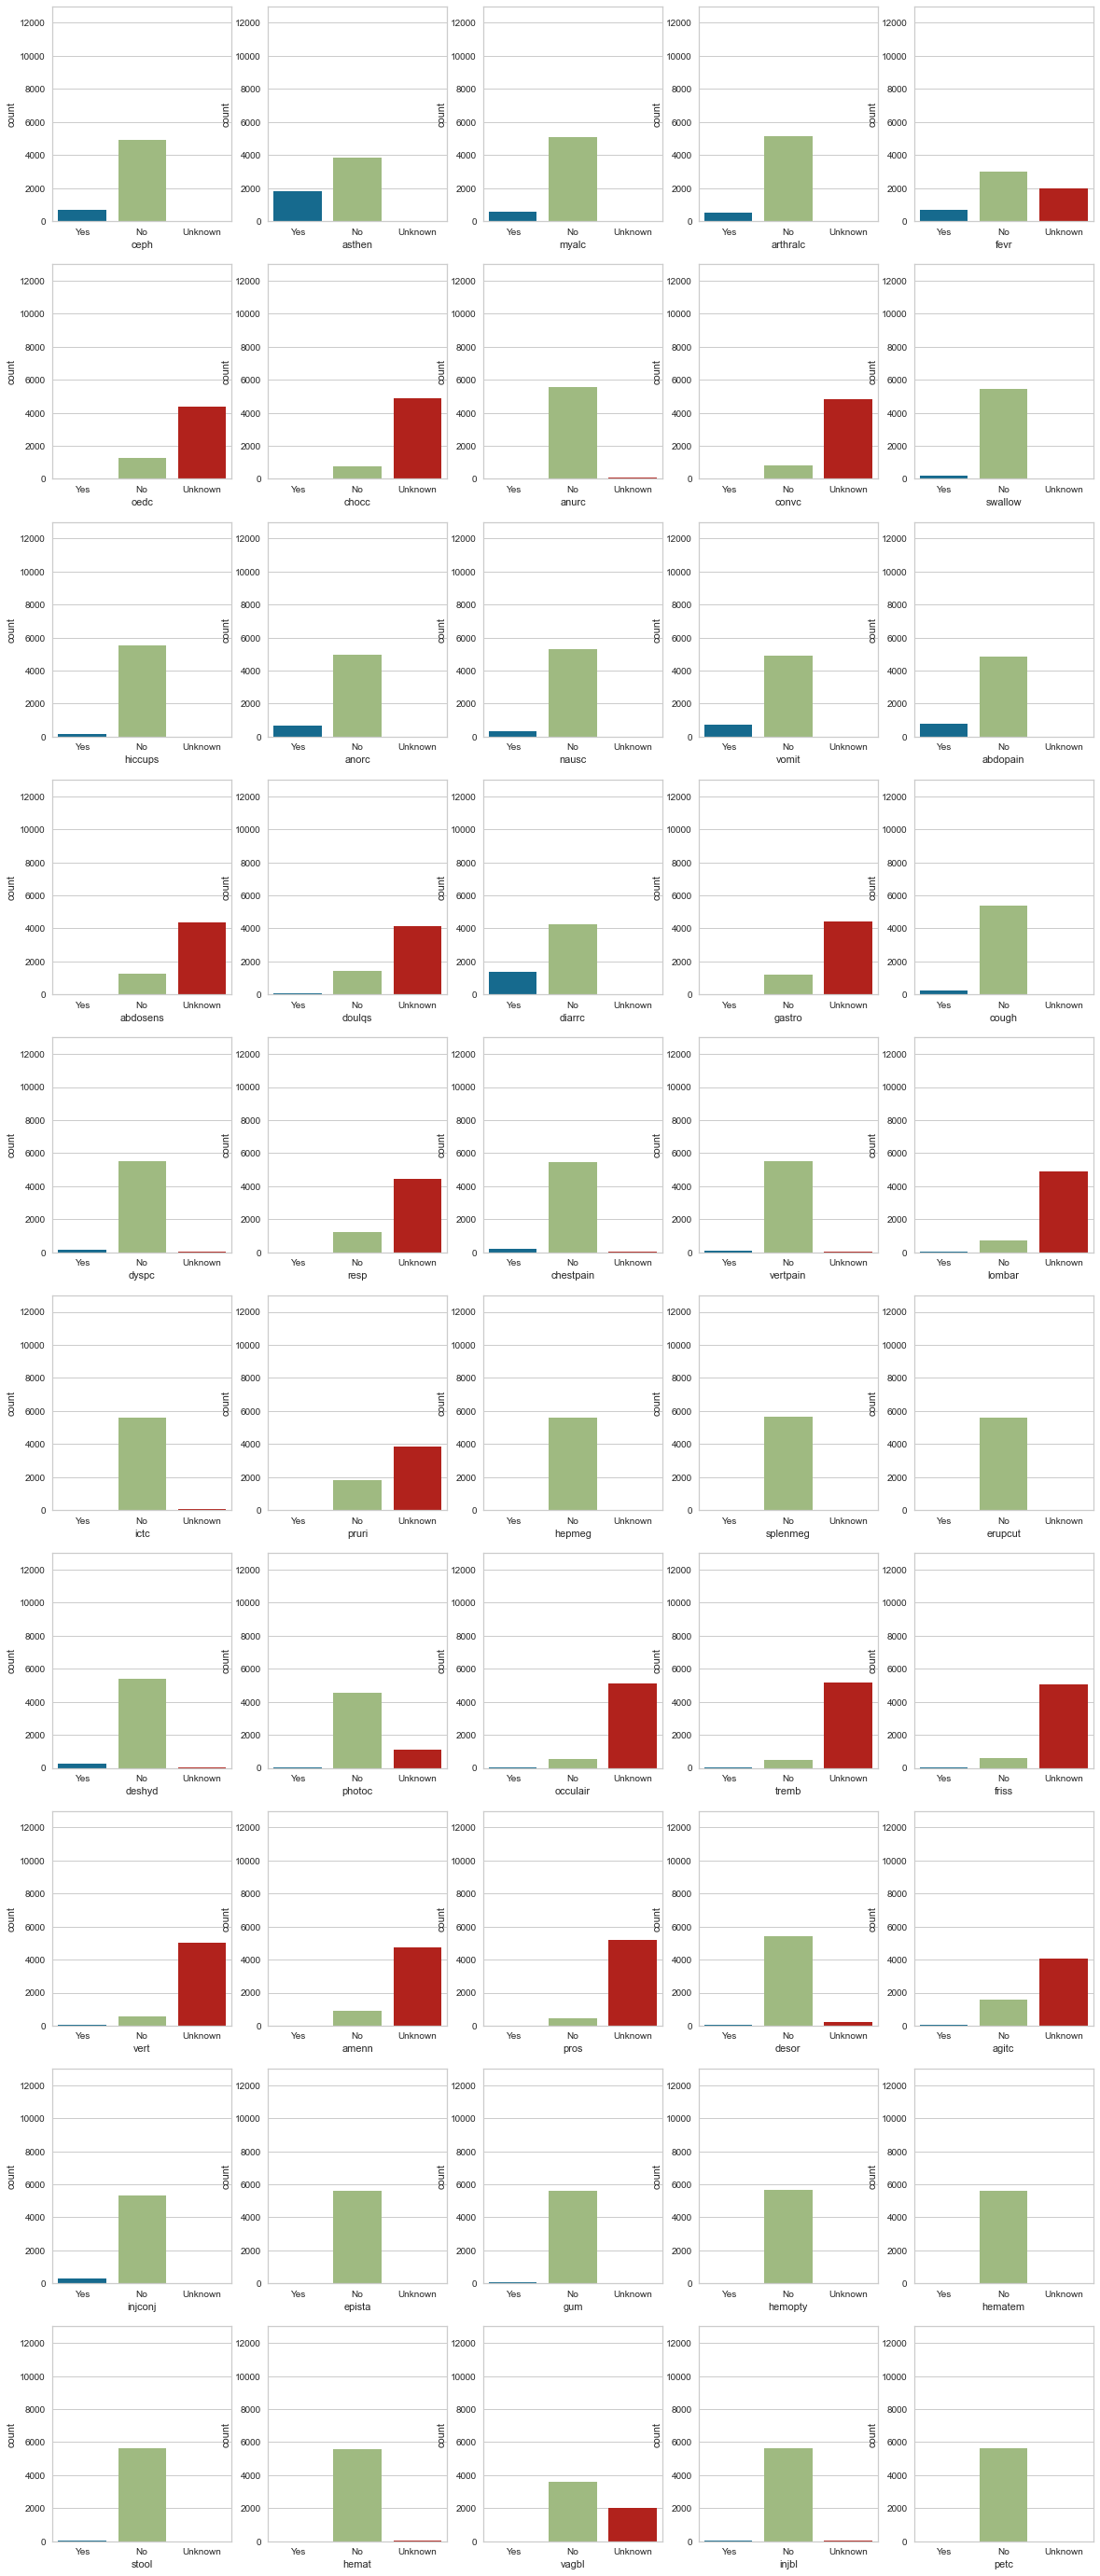

In [59]:
fig, axes = plt.subplots(nrows = 10, ncols=5, figsize=(20,50))
for ax, col in zip(axes.flatten(), df_symp.columns):
    sns.countplot(df_symp[col], ax = ax, order = ['Yes', 'No', 'Unknown'])
    #plt.title('Distribution of the symptom {}'.format(col))
    ax.set_ylim(0, 13000)

## Even though it seems on the graph that we "only" have unknown values and no's, we must remember that these are the clinical data where each patient is measured within a whole day

In [60]:
yes_series = df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 ).apply(lambda x :sum(x))
no_series = df_symp.applymap(lambda x : 1 if x== 'No' else 0 ).apply(lambda x :sum(x))
unknown_series = df_symp.applymap(lambda x : 1 if x== 'Unknown' else 0 ).apply(lambda x :sum(x))

In [61]:
count_symptoms = pd.concat([yes_series, no_series, unknown_series], axis=1)
count_symptoms.columns = ['Yes', 'No', 'Unknown']
total_observations = 13598
(count_symptoms / total_observations).sort_values(by ='Unknown')

,Yes,No,Unknown
diarrc,0.101412,0.313796,0.000662
asthen,0.132740,0.282321,0.000809
vomit,0.055376,0.359685,0.000809
chestpain,0.015076,0.399838,0.000956
cough,0.018973,0.395867,0.001030
hepmeg,0.002059,0.412781,0.001030
splenmeg,0.001030,0.413811,0.001030
nausc,0.024857,0.389984,0.001030
dyspc,0.009266,0.405574,0.001030
petc,0.000221,0.414620,0.001030


#### Correlation between symptoms

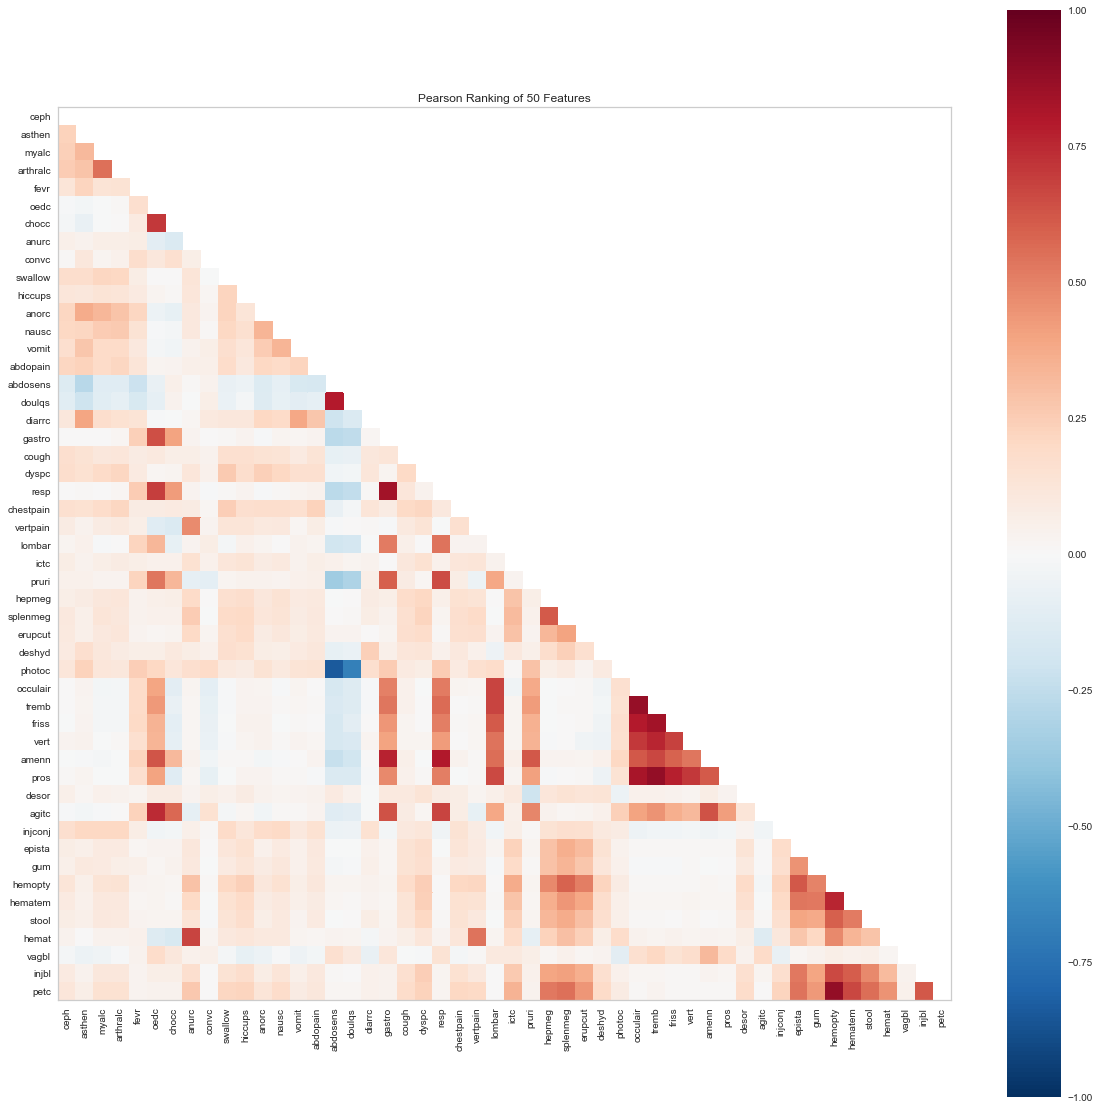

In [62]:
dict_symp = {'Unknown' : -1, 'No' : 0 , 'Yes' : 1}

Corr_vision(df_symp.applymap(lambda x : dict_symp[x]))

It is important to note that we cannot just remove highly correlated features, imagine big feat and vommiting had a high corelation because the few people you surveyed had both. If the model removes vomit but keep big feet, it would be really be understable 

In [63]:
# We cannot separate the or can we ? since 235 out of 11'000
df_naus_vom = df_symp.groupby(by = ['vomit','nausc'])[['nausc']].count()
df_naus_vom.columns = ['count']
df_naus_vom

count
vomit   nausc         
No      No        4746
        Yes        145
Unknown Unknown     11
Yes     No         557
        Unknown      3
        Yes        193

In [64]:
# abdosens does not bring much valuable infomration here, we remove it 

# Both abdosens and doulqs refer to pain in the chest area
df_sens = df_symp.groupby(by = ['abdosens','doulqs'])[['doulqs']].count()
df_sens.columns = ['count']
df_sens

count
abdosens doulqs        
No       No        1265
         Unknown      2
         Yes         12
Unknown  No         148
         Unknown   4134
         Yes         87
Yes      No           1
         Unknown      6

In [65]:
df_symp.drop(columns = ['abdosens'], inplace = True)

In [66]:
# Let's look at two similar breathing problems 
#Dyspnée (Short of Breath)
#signes détresse respiratry

df_resp = df_symp.groupby(by = ['dyspc','resp'])[['resp']].count()
df_resp.columns = ['count']
df_resp

count
dyspc   resp          
No      No        1172
        Unknown   4341
        Yes          2
Unknown Unknown     13
        Yes          1
Yes     No          33
        Unknown     89
        Yes          4

In [67]:
df_symp.drop(columns = ['resp'], inplace = True)

In [68]:
# Back pain
df_back = df_symp.groupby(by = ['lombar','vertpain'])[['vertpain']].count()
df_back.columns = ['count']
df_back


count
lombar  vertpain       
No      No          690
        Yes          14
Unknown No         4782
        Unknown      60
        Yes          71
Yes     No           37
        Yes           1

In [69]:
df_symp.drop(columns = ['lombar'], inplace = True)

In [70]:
# Eye pain/sensitivity
df_eye = df_symp.groupby(by = ['photoc','occulair'])[['occulair']].count()
df_eye.columns = ['count']
df_eye

# we can remove occulair as it provides no additional information

count
photoc  occulair       
No      No          560
        Unknown    3979
        Yes           2
Unknown Unknown    1108
Yes     Unknown       6

In [71]:
df_symp.drop(columns = ['occulair'], inplace = True)

In [72]:
# Might add some more 

<AxesSubplot:>

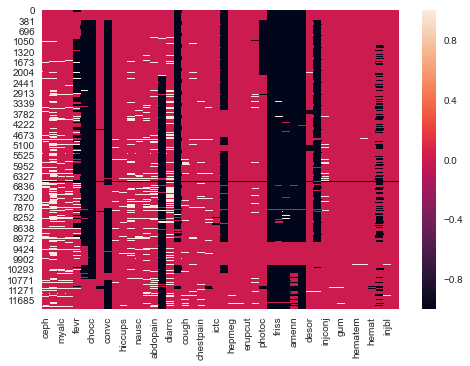

In [73]:
df_symp.eq('Unknown', axis=0).all(1)
sns.heatmap(df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 if x == 'No' else -1 ))

The black corresponds to unknowns

In [74]:
tot_rows = 12705;

#### Missing column data

In [75]:
cols = df_symp.columns
df_symp[cols].eq('Unknown').sum(axis=0)/tot_rows 

# remove after 20 % 

ceph         0.001259
asthen       0.000866
myalc        0.001102
arthralc     0.001181
fevr         0.156789
oedc         0.345140
chocc        0.383707
anurc        0.005588
convc        0.381189
swallow      0.001102
hiccups      0.001181
anorc        0.001338
nausc        0.001102
vomit        0.000866
abdopain     0.001417
doulqs       0.326013
diarrc       0.000708
gastro       0.346714
cough        0.001102
dyspc        0.001102
chestpain    0.001023
vertpain     0.004723
ictc         0.004880
pruri        0.301771
hepmeg       0.001102
splenmeg     0.001102
erupcut      0.002283
deshyd       0.001259
photoc       0.087210
tremb        0.406612
friss        0.398583
vert         0.396616
amenn        0.374105
pros         0.407005
desor        0.016529
agitc        0.318142
injconj      0.001259
epista       0.001102
gum          0.001102
hemopty      0.001102
hematem      0.001102
stool        0.001102
hemat        0.004172
vagbl        0.159465
injbl        0.001181
petc      

In [76]:
df_symp.columns

Index(['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc',
       'convc', 'swallow', 'hiccups', 'anorc', 'nausc', 'vomit', 'abdopain',
       'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'chestpain', 'vertpain',
       'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc',
       'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj',
       'epista', 'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl',
       'injbl', 'petc'],
      dtype='object')

In [77]:
# remove for the 0.004


In [78]:
df_symp

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
5,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12048,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12050,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
12051,No,No,No,No,No,No,No,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No


In [79]:
###################### Redo after havin removed 20%
# Here I kept symptoms with more than 80 % of the data
#vertpain, ictc,photoc (more around 15 % missing ....)
few_miss = df_symp[['ceph', 'asthen', 'myalc', 'arthralc', 'anurc',
        'swallow', 'hiccups', 'anorc', 'nausc', 'vomit', 'abdopain',
        'diarrc',  'cough', 'dyspc', 'chestpain',
       'vertpain', 'ictc',  'hepmeg', 'splenmeg', 'erupcut',
       'deshyd', 'photoc',   'desor',
       'injconj', 'epista', 'gum', 'hemopty', 'hematem', 'stool',
       'hemat', 'injbl', 'petc']]

In [875]:
# the one with around 0.004 have many patients in common, not sure if patients  .....hum 

In [1219]:
a =df_symp.index[df_symp['dyspc'] == 'Unknown') & (df_symp['injconj'] == 'Unknown')].tolist()

ValueError: Lengths must match to compare

In [878]:
c =df_symp.index[df_symp['cough'] == 'Unknown'].tolist()

In [879]:
d = df_symp.index[df_symp['hematem'] == 'Unknown'].tolist()

In [880]:
print(set(a).intersection(c).intersection(b).intersection(d))

{8576, 8577, 8578, 8579, 8575, 8200, 7947, 7948, 8206, 7957, 8598, 9110, 4504, 8475, 8232, 12975, 12976, 5553, 12977, 12978, 12979, 12986, 9031, 9032, 9033, 7628, 7629, 7630, 7631, 9039, 7633, 7641, 7649, 7652, 8808, 7657, 8173, 8174, 9205, 9078, 6008, 8572, 8573, 8574, 8063}


**Possibility 1 :** Use categorical features for symptoms then need 1 hot encoding.

In [881]:
df_hot =df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 )

df_hot.head()


,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Possibility 2 :** Use numerical features for symptoms as the number of observed symptoms.

Now we want the cumulated observations per patient. 

In [882]:
df_yes_symp = df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 )
df_yes_symp['id_patient'] = df['msfid']
df_yes_symp_patient = df_yes_symp.groupby('id_patient').sum()
df_yes_symp_patient

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
id_patient,,,,,,,,,,,,,,,,,,,,,
G100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1000,0,2,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
G1001,1,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1002,0,3,0,0,3,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
G1004,0,2,1,0,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G993,4,20,5,1,9,0,0,0,0,2,...,1,0,0,0,0,1,0,0,0,0
G994,2,11,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
G996,1,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Possibility 3 :** Use binary features for symptoms as the presence of symtoms (1 for 'Yes' and 0 for 'No' or 'Unknown')

We can try to predict with these features, number of observations for which the symptom has been observed. 

In [883]:
df_presence_symp_patient = df_yes_symp_patient.applymap(lambda x: 1 if x>= 1 else 0 )
df_presence_symp_patient

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
id_patient,,,,,,,,,,,,,,,,,,,,,
G100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1000,0,1,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
G1001,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G1002,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
G1004,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G993,1,1,1,1,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
G994,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
G996,1,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [884]:
df

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,datclin_day,datclin_month
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-14,2014-04
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-14,2014-04
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,7.0,2014-04-16,2014-04
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-15,2014-04
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-15,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,G1841,2014-11-20,9,G1841_20nov2014_9,0,0,0,0,8,8,...,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0,2014-11-20,2014-11
13762,G1841,2014-11-20,16,G1841_20nov2014_16,0,0,0,0,8,8,...,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0,2014-11-20,2014-11
13763,G1841,2014-11-21,9,G1841_21nov2014_9,0,0,0,0,8,8,...,Yes,0,2014-11-05,1.0,1,40.0,1.0,16.0,2014-11-21,2014-11
13764,G1934,2014-11-16,9,G1934_16nov2014_9,1,1,1,1,1,0,...,Yes,0,2014-11-12,1.0,1,40.0,1.0,4.0,2014-11-16,2014-11


### Numerical symptoms

#### Fever temperature

In [885]:
sum(df['fevtemp'].isna())

0

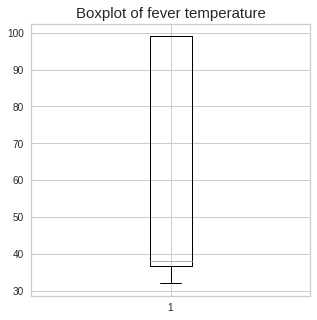

In [886]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of fever temperature",size=15)
plt.boxplot(df['fevtemp'])
plt.show()

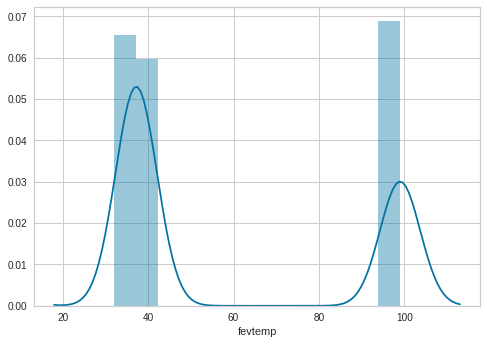

In [887]:
sns.distplot(df["fevtemp"])
plt.show()

*We observe that the fever temperature is actually measured in 2 different units,  Celcius and Fahrenheit.

In [888]:
bins = np.array([0, 20, 50, 80, 120])
inds = np.digitize(df['fevtemp'], bins)
count_fev_catg = pd.Series(inds).value_counts()
count_fev_catg.index = ['Celcius', 'Fahrenheit']
count_fev_catg

Celcius       8745
Fahrenheit    4810
dtype: int64

If the values is bigger than 50 we assume that it's measured in Fahrenheit and we transform it in Celcius. 

In [889]:
df['fevtemp'] = df['fevtemp'].apply(lambda x: (x - 32) * 5./9. if x > 50 else x)

<ipython-input-889-21f544f6c389>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fevtemp'] = df['fevtemp'].apply(lambda x: (x - 32) * 5./9. if x > 50 else x)


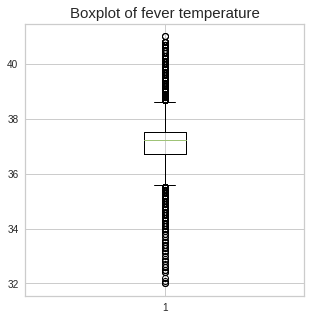

In [890]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of fever temperature",size=15)
plt.boxplot(df['fevtemp'])
plt.show()

#### Heart beat

In [893]:
df['pouls'].value_counts(dropna = False)

999    13163
100       48
80        48
90        31
99        24
120       18
88        18
60        17
84        17
110       13
70        13
68        11
92         9
98         9
96         8
76         8
86         8
108        7
82         7
118        6
78         6
102        4
72         4
104        4
89         4
74         3
112        3
64         3
77         3
85         3
103        2
62         2
109        2
.          2
106        2
66         2
127        2
115        2
136        2
121        1
91         1
38         1
107        1
142        1
94         1
160        1
114        1
130        1
87         1
79         1
71         1
141        1
117        1
124        1
116        1
95         1
Name: pouls, dtype: int64

We have 2 Nan values and two '.' we set them to 999.0 default value for now. 


In [894]:
df['pouls'].fillna(999, inplace = True)
df['pouls'].replace('.', 999, inplace = True)

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [899]:
df['pouls'] = df['pouls'].astype('int')
df[df['pouls'] == 999].count()

<ipython-input-899-4928ebc2273b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pouls'] = df['pouls'].astype('int')


msfid            13165
datclin          13165
timclin          13165
unid             13165
ceph             13165
                 ...  
age              13165
sex              13165
dt               13165
datclin_day      13165
datclin_month    13165
Length: 120, dtype: int64

In [900]:
missing_pouls = 13165
total_obvs = df['msfid'].count()

In [901]:
ratio_pouls = missing_pouls / total_obvs
ratio_pouls

0.9712283290298783

We have a lot of missing values of the heartbeat, it's not taken at each observations. Let see if we have at least one heartbeat for each patient.

In [902]:
df[df['pouls'] != 999].groupby('msfid').pouls.count()

msfid
G1005    1
G1006    1
G1008    1
G1009    1
G1010    1
        ..
G703     1
G741     1
G746     1
G751     3
G768     1
Name: pouls, Length: 91, dtype: int64

In [903]:
sum(df[df['pouls'] != 999.0].groupby('msfid').pouls.count()) / total_obvs

0.028771670970121725

In [904]:
91/df['msfid'].nunique()

0.11833550065019506

We only have the heartbeat for 91 patients, that is 11% of the cohort and only for 2.8% of the observations. 

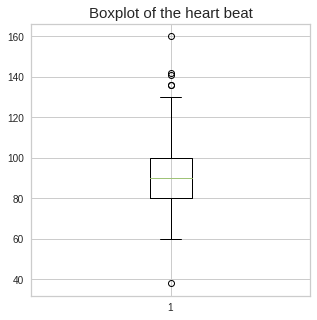

In [905]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of the heart beat",size=15)
plt.boxplot(df.loc[df['pouls'] != 999.0,'pouls'])
plt.show()

### Drop pouls ? 2.8 % observations....yes

#### Blood pressure

In [906]:
df['bp'].value_counts(dropna = False)

999    7059
999    5311
100     235
80      221
90      186
110     129
70       76
90       66
120      61
100      37
80       23
60       22
70       19
110      14
120      12
130      11
99        8
140       7
10        6
60        5
7         4
160       4
11        3
50        3
150       2
10        2
180       2
12        2
85        2
150       2
140       2
75        2
67        1
8         1
95        1
125       1
13        1
15        1
111       1
78        1
84        1
74        1
104       1
130       1
40        1
121       1
11        1
.         1
114       1
Name: bp, dtype: int64

In [907]:
df['bp'].fillna(999.0, inplace = True)
df['bp'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df['bp'] = df['bp'].astype('int')

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-907-e29b7f5b0fb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [908]:
df[df['bp'] != 999.0].groupby('msfid').bp.count()

msfid
G1004    1
G1005    2
G1006    4
G1007    2
G1008    2
        ..
G989     1
G991     3
G992     3
G993     8
G994     5
Name: bp, Length: 314, dtype: int64

In [909]:
sum(df[df['bp'] != 999.0].groupby('msfid').bp.count())/ total_obvs

0.08734784212467724

In [910]:
patient_np = len(df[df['bp'] != 999.0].groupby('msfid').bp.count())

patient_np / df['msfid'].nunique()

0.4083224967490247

We have the bloodpressure for 313 patients, that is 40% of the cohort and 8% of the observations. 

In [911]:
f = {'bp': ['count','mean', 'median', 'std', 'skew', pd.DataFrame.kurt, lambda x : x.quantile(0.25), lambda x : x.quantile(0.75)]}
df.loc[:,['msfid','bp']].groupby('msfid').agg(f).fillna(0).rename(columns={"<lambda_0>": "first quartile", "<lambda_1>": "third quartile "})

bp                                                                    \
      count        mean median         std      skew      kurt first quartile   
msfid                                                                           
G100     30  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G1000     3  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G1001     5  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G1002    43  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G1004     3  686.000000  999.0  542.131903 -1.732051  0.000000          529.5   
...     ...         ...    ...         ...       ...       ...            ...   
G993     31  763.451613  999.0  406.001382 -1.162993 -0.696576          544.5   
G994     14  675.071429  999.0  451.127556 -0.672318 -1.831771          105.0   
G996      5  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G998     20  999.000000  999.0    0.000000  0.000000  0.000000          999.0   
G999      4  999.000000  999.0    0.000000  0.000000  0.000000          999.0   

                       
      third quartile   
msfid                  
G100            999.0  
G1000           999.0  
G1001           999.0  
G1002           999.0  
G1004           999.0  
...               ...  
G993            999.0  
G994            999.0  
G996            999.0  
G998            999.0  
G999            999.0  

[769 rows x 8 columns]

#### Drop blood pressure ? 8% obvs yes

#### Respiration Rate

In [912]:
df['rrate'].value_counts(dropna = False)


999    7641
999    5503
24       52
20       44
28       38
26       37
32       35
22       34
40       21
30       19
36       14
23       10
25       10
27        9
19        9
18        8
42        7
30        6
34        5
48        5
99        3
46        3
44        3
99        3
45        3
56        3
16        3
60        2
37        2
90        2
39        2
21        2
38        2
100       2
98        1
92        1
52        1
80        1
41        1
80        1
70        1
.         1
43        1
33        1
29        1
54        1
16        1
Name: rrate, dtype: int64

In [913]:
df['rrate'].fillna(999.0, inplace = True)
df['rrate'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df['rrate'] = df['rrate'].astype('int')


/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-913-0bb99a013ead>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [914]:
df[df['rrate'] != 999.0].groupby('msfid').rrate.count()

msfid
G1005    1
G1006    1
G1009    1
G1010    1
G1013    2
        ..
G671     1
G674     1
G704     1
G711     1
G768     1
Name: rrate, Length: 88, dtype: int64

In [915]:
sum(df[df['rrate'] != 999.0].groupby('msfid').rrate.count())/ total_obvs

0.030247141276281815

In [916]:
patients_rrate = len(df[df['rrate'] != 999.0].groupby('msfid').rrate.count())

ratio_rrate = patients_rrate / df['msfid'].nunique()
ratio_rrate

0.11443433029908973

We have the respiration rate for 88 patients, that is 11% of the cohort and 3% of the observations. 

## respiratory rate only 3 % drop ? yes

#### Other categorical symptoms

In [917]:
df['deshcat'].value_counts()

Non rempli                                10227
Pas applicable (non inclus dans fiche)     3290
B: irritable and restless, sunke             15
C: floppy baby/lethargic or unco             14
A: alert, eyes normal, not thirs              8
.                                             1
Name: deshcat, dtype: int64

In [918]:
dict_deshcat = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans fiche)' : 'Unknown', \
               'A: alert, eyes normal, not thirs' : 'Alert', 'B: irritable and restless, sunke' : 'Irritable', \
               'C: floppy baby/lethargic or unco' : 'Lethargic', '.' : 'Unknown'}

df['deshcat'] = df['deshcat'].apply(lambda x: dict_deshcat[x])

<ipython-input-918-b60605eb2b54>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deshcat'] = df['deshcat'].apply(lambda x: dict_deshcat[x])


In [919]:
# deshcat () different than unknown

df.loc[df['deshcat'] != 'Unknown'].groupby('msfid').deshcat.count()

msfid
G1570    3
G1624    1
G1768    1
G1803    5
G1804    3
G1901    2
G1903    4
G1932    1
G1934    2
G2078    1
G2102    1
G577     1
G580     1
G645     1
G647     1
G761     1
G769     1
G782     1
G788     2
G792     3
G867     1
Name: deshcat, dtype: int64

#### very few values


The Glasgow Coma Scale (GCS) is used to objectively describe the extent of impaired **consciousness** in all types of acute medical and trauma patients. The scale assesses patients according to three aspects of responsiveness: eye-opening, motor, and verbal responses. Reporting each of these separately provides a clear, communicable picture of a patient’s state.
More in https://www.ncbi.nlm.nih.gov/books/NBK513298/#:~:text=%5B1%5D%20The%20Glasgow%20Coma%20Scale,%2C%20motor%2C%20and%20verbal%20responses.

In [ ]:
# we should keep the one below

### Look how often the patients are tested for this


In [951]:
df

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,epilep,mendis,datsym,epistat,outcome,age,sex,dt,datclin_day,datclin_month
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-14,2014-04
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-14,2014-04
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,2014-04-09,1.0,1,40.0,1.0,7.0,2014-04-16,2014-04
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-15,2014-04
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-15,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,G1841,2014-11-20,9,G1841_20nov2014_9,0,0,0,0,8,8,...,8,8,2014-11-05,1.0,1,40.0,1.0,15.0,2014-11-20,2014-11
13762,G1841,2014-11-20,16,G1841_20nov2014_16,0,0,0,0,8,8,...,8,8,2014-11-05,1.0,1,40.0,1.0,15.0,2014-11-20,2014-11
13763,G1841,2014-11-21,9,G1841_21nov2014_9,0,0,0,0,8,8,...,8,8,2014-11-05,1.0,1,40.0,1.0,16.0,2014-11-21,2014-11
13764,G1934,2014-11-16,9,G1934_16nov2014_9,1,1,1,1,1,0,...,8,8,2014-11-12,1.0,1,40.0,1.0,4.0,2014-11-16,2014-11


In [963]:
df['conscc'].value_counts()

Unknown                       12789
Alert: GCS in [13,15]           485
Unresponsive: GCS in [1,3]      122
Voice: GCS in [9,12]             80
Pain GCS in [4,8]                79
Name: conscc, dtype: int64

In [964]:
df_cons = df.loc[(df['conscc'] != 'Unknown'),['conscc','msfid']].groupby(by = 'msfid').count()

In [965]:
df_cons

,conscc
msfid,
G1002,2
G1004,1
G1008,1
G1009,2
G1010,5
...,...
G989,1
G991,1
G993,6


In [966]:
(df_cons != 0).sum()

conscc    270
dtype: int64

In [921]:
dict_deshcat = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans' : 'Unknown', \
               'Alert GCS=13,14,15' : 'Alert: GCS in [13,15]', 'Unresponsive GCS=1,2,3' : 'Unresponsive: GCS in [1,3]', \
               'Pain GCS=4,5,6,7,8' : 'Pain GCS in [4,8]', 'Voice GCS=9,10,11,12' : 'Voice: GCS in [9,12]', \
               '.' : 'Unknown'}

df['conscc'] = df['conscc'].apply(lambda x: dict_deshcat[x])

<ipython-input-921-c676e89e78b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conscc'] = df['conscc'].apply(lambda x: dict_deshcat[x])


In [968]:
df.loc[df['conscc'] != 'Unknown'].groupby('msfid').conscc.count().sort_values(ascending = False)

msfid
G1775    23
G2134    20
G1622    15
G747     14
G1068    12
         ..
G735      1
G734      1
G712      1
G1728     1
G591      1
Name: conscc, Length: 270, dtype: int64

In [975]:
df[(df['msfid'] == 'G1775')].datclin.nunique()

21

#### Too few data above right ? 

### Further data analysis 

We will drop the feature "cta" where the dictionary does is "not sure" of what it is and alos dup (no legend on dictionary)
'otherco': other-comorbidities is also removed to the lack of values
'notesread': Were 50 % of notes readable


In [923]:
df['cta'].value_counts()

0    8933
8    2462
.    1789
9     195
1     176
Name: cta, dtype: int64

In [924]:
df['dup'].value_counts()

0    13542
1       13
Name: dup, dtype: int64

In [925]:
df['notesread'].value_counts()

Yes    9618
.      3121
No      816
Name: notesread, dtype: int64

In [926]:
df['othrtx'].value_counts()

.                      7419
ABSENT                 2272
FAVIPIRAVIR             540
na                      502
ONDANSETRON             178
                       ... 
ORDANSETRON               1
EAU                       1
glucose IV                1
POTASSIUM, BUSCOPAN       1
jus, Eau                  1
Name: othrtx, Length: 185, dtype: int64

In [927]:
df.drop(columns = ['cta','dup','notesread','otherco'], inplace = True)

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Treatments 

What shall I do with "parat" <malaria test>
and "malari" <malaria positive>

'parat', 'coartt', 'artest', 'ppnt',
       'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt',
       'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz', 'cta', 'metro',
       'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro',
       'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso',
       'zinc', 'othrtx', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc',
       'perfal', 'malari', 'hivpos', 'mningit', 'encphal', 'erysip',
       'cardio', 'fessier', 'epilep', 'mendis', 'otherco', 'notesread',
       'dup',

In [928]:
df_treat = df[['coartt', 'artest', 'ppnt',\
       'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt',\
       'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz','metro',\
       'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro',\
       'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso',\
       'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc',\
       'perfal']]

In [929]:
df_treat

,coartt,artest,ppnt,orst,paracett,ciprot,cefixt,ceftriaxt,multivitt,metaclot,...,mysta,busco,miso,zinc,ivcare,rlt,rltg,rltk,gluc,perfal
0,0,0,0,0,1,0,1,0,1,0,...,.,.,.,.,0,0,0,0,.,.
1,0,0,0,0,0,0,0,0,0,0,...,.,.,.,.,0,0,0,0,.,.
2,0,0,0,0,0,0,1,0,0,0,...,.,.,.,.,0,0,0,0,.,.
3,0,0,0,0,0,0,0,0,0,0,...,.,.,.,.,0,0,0,0,.,.
4,0,0,0,0,1,0,1,0,1,0,...,.,.,.,.,0,0,0,0,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,8,8,0,1,0,8,8,8,8,1,...,8,8,8,8,8,8,8,8,8,8
13762,8,8,0,1,0,8,8,8,8,1,...,8,8,8,8,8,8,8,8,8,8
13763,8,8,0,1,0,8,8,8,8,1,...,8,8,8,8,8,8,8,8,8,8
13764,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [930]:
dict_treat = {0:0, 1:1, 9:-1, '.':-1, '0': 0,'1': 1,'8':-1,'9':-1, -1:-1}

df_treat = df_treat.applymap(lambda x : dict_treat[x])

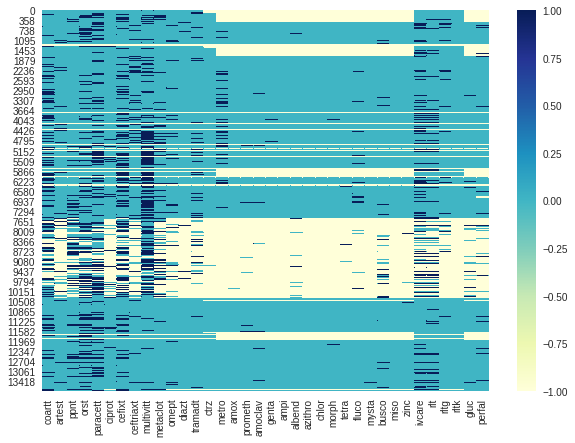

In [931]:
f, ax = plt.subplots(figsize=(10, 7))

ax = sns.heatmap(df_treat, cmap="YlGnBu")



The white represnets the missing data, the blue the positive andthe light blue negative.

we see many unknwon values for the range between 7500 and 10'000


# Ask Ridha what he thinks

['coartt', 'artest', 'ppnt',\
       'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt',\
       'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz','metro',\
       'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro',\
       'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso',\
       'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc',\
       'perfal']

In [932]:
df_treat['coartt'].value_counts()

 0    8636
 1    3309
-1    1610
Name: coartt, dtype: int64

### Results

In [933]:
df_tests 

,malari,hivpos,mningit,encphal,erysip,cardio,fessier,epilep,mendis,epistat
0,.,.,.,.,.,.,.,.,.,1.0
1,.,.,.,.,.,.,.,.,.,1.0
2,.,.,.,.,.,.,.,.,.,1.0
3,.,.,.,.,.,.,.,.,.,1.0
4,.,.,.,.,.,.,.,.,.,1.0
...,...,...,...,...,...,...,...,...,...,...
13761,8,8,8,8,8,8,8,8,8,1.0
13762,8,8,8,8,8,8,8,8,8,1.0
13763,8,8,8,8,8,8,8,8,8,1.0
13764,1,8,8,8,8,8,8,8,8,1.0


In [934]:
df_tests = df[['malari', 'hivpos', 'mningit', 'encphal', 'erysip', \
       'cardio', 'fessier', 'epilep', 'mendis', 'epistat']]

In [935]:
# We also have the outcome, but it needs a different dictionary ! 
df['outcome'].value_counts()

1    8285
2    5111
.     104
3      53
4       2
Name: outcome, dtype: int64

#### We are however only interested in healed or deceased in our case (for the outcome)
1	Guéri : Healed
2	Décédé : Deceased
3	Transferé : Transfered
4	Evadé : Escaped
9	Non rempli : Not filled in


In [936]:
dict_outcome = {1:1, 2:0, 9:np.nan, '.':np.nan, '0': np.nan,'1':1,'2':0,'4':np.nan,'3':np.nan}

In [937]:
df_out = df['outcome'].apply(lambda x : dict_outcome[x])

In [938]:
df_out.value_counts()

1.0    8285
0.0    5111
Name: outcome, dtype: int64

In [939]:
df_tests['epistat'].value_counts()

1.0    13423
0.0      132
Name: epistat, dtype: int64

In [940]:
df_tests

,malari,hivpos,mningit,encphal,erysip,cardio,fessier,epilep,mendis,epistat
0,.,.,.,.,.,.,.,.,.,1.0
1,.,.,.,.,.,.,.,.,.,1.0
2,.,.,.,.,.,.,.,.,.,1.0
3,.,.,.,.,.,.,.,.,.,1.0
4,.,.,.,.,.,.,.,.,.,1.0
...,...,...,...,...,...,...,...,...,...,...
13761,8,8,8,8,8,8,8,8,8,1.0
13762,8,8,8,8,8,8,8,8,8,1.0
13763,8,8,8,8,8,8,8,8,8,1.0
13764,1,8,8,8,8,8,8,8,8,1.0


TypeError: unsupported operand type(s) for /: 'str' and 'int'

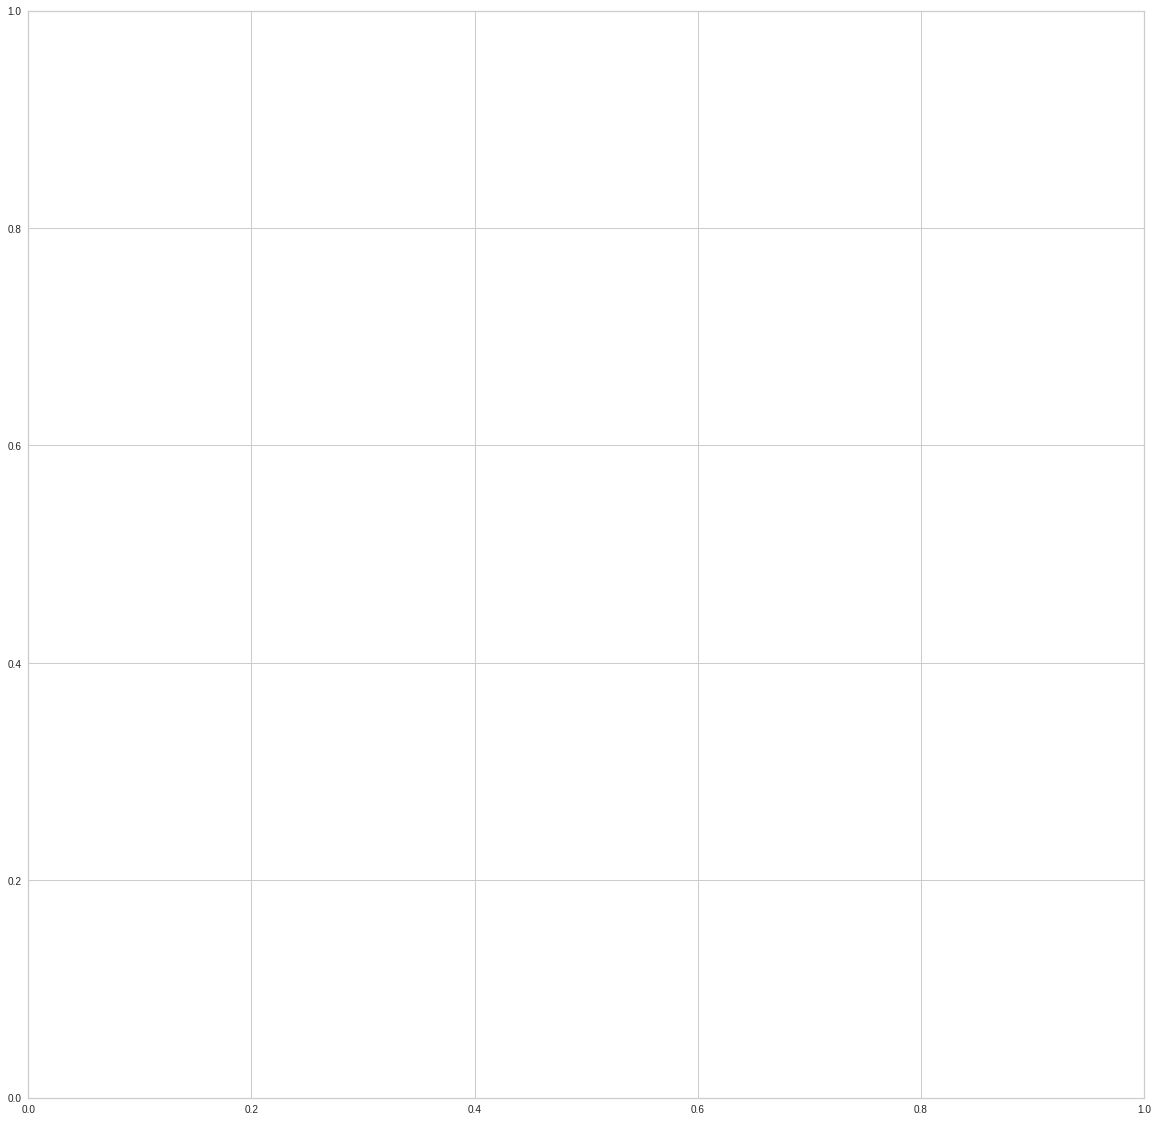

In [941]:
Corr_vision(df_tests).applymap(lambda x : dict_treat[x])